In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-14 11:07:57.860470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 11:07:59.221287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
input_shape_2D=(250,250)
input_shape_3D= (250,250,3)
seeds=41
batch_size=32
epochs=10

In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 2100 files belonging to 6 classes.


2024-04-14 11:08:11.761794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:08:11.810354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:08:11.810736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
valid_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/validation',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 528 files belonging to 6 classes.


In [5]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [6]:
X=[]
y= []

for image, label in data_ds.batch(2099):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [7]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seeds)

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1680, 250, 250, 3)
shape of y_train: (1680,)
shape of X_test_scaled: (420, 250, 250, 3)
shape of y_test: (420,)


In [11]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

## VGG16

In [12]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
   
vgg_base.trainable = False  
  
set_trainable = False  

for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  
  
vgg_model = Sequential()  
  
vgg_model.add(vgg_base)  
  

vgg_model.add(Flatten())  

vgg_model.add(Dense(200, activation='relu'))  

vgg_model.add(Dense(6, activation='softmax'))  


58889256/58889256 [==============================] - 3s 0us/step


In [13]:
#compiling 
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 200)               5017800   
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 19733694 (75.28 MB)
Trainable params: 5019006 (19.15 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
utils.plot_model(
    vgg_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
import time
# Record the start time of training
start_time = time.time()

In [16]:
# Train the model
epochs = 10

#Training
history = vgg_model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs)

Epoch 1/10


2024-04-14 11:09:10.867859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-14 11:09:13.463495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-14 11:09:13.750527: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e610650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-14 11:09:13.750612: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-14 11:09:13.904394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 11:09:14.583403: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 12s 101ms/step - loss: 1.3482 - accuracy: 0.5839 - val_loss: 0.7486 - val_accuracy: 0.7310
Epoch 2/10
53/53 [==============================] - 4s 80ms/step - loss: 0.4694 - accuracy: 0.8304 - val_loss: 0.5807 - val_accuracy: 0.7690
Epoch 3/10
53/53 [==============================] - 4s 82ms/step - loss: 0.3259 - accuracy: 0.8804 - val_loss: 0.4308 - val_accuracy: 0.8238
Epoch 4/10
53/53 [==============================] - 4s 82ms/step - loss: 0.2238 - accuracy: 0.9244 - val_loss: 0.5157 - val_accuracy: 0.8214
Epoch 5/10
53/53 [==============================] - 4s 83ms/step - loss: 0.1837 - accuracy: 0.9405 - val_loss: 0.4125 - val_accuracy: 0.8310
Epoch 6/10
53/53 [==============================] - 4s 83ms/step - loss: 0.1268 - accuracy: 0.9685 - val_loss: 0.3811 - val_accuracy: 0.8262
Epoch 7/10
53/53 [==============================] - 4s 83ms/step - loss: 0.1265 - accuracy: 0.9607 - val_loss: 0.4318 - val_accuracy: 0.8548
Epoch 8/10
53/53 [====

In [17]:
# Record the training end time
end_time = time.time()

In [18]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 87.41812300682068 seconds


In [19]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.348160,0.583929,0.748647,0.730952
1,0.469351,0.830357,0.580698,0.769048
2,0.325930,0.880357,0.430848,0.823810
3,0.223822,0.924405,0.515679,0.821429
4,0.183744,0.940476,0.412457,0.830952
5,0.126825,0.968452,0.381132,0.826190
6,0.126454,0.960714,0.431828,0.854762
7,0.069764,0.988690,0.311320,0.878571
8,0.044306,0.995833,0.294696,0.888095
9,0.034430,0.998214,0.296999,0.888095


In [20]:
import joblib

joblib.dump(history.history,'history_VGG.pkl')
history_CNN2 = joblib.load('history_VGG.pkl')

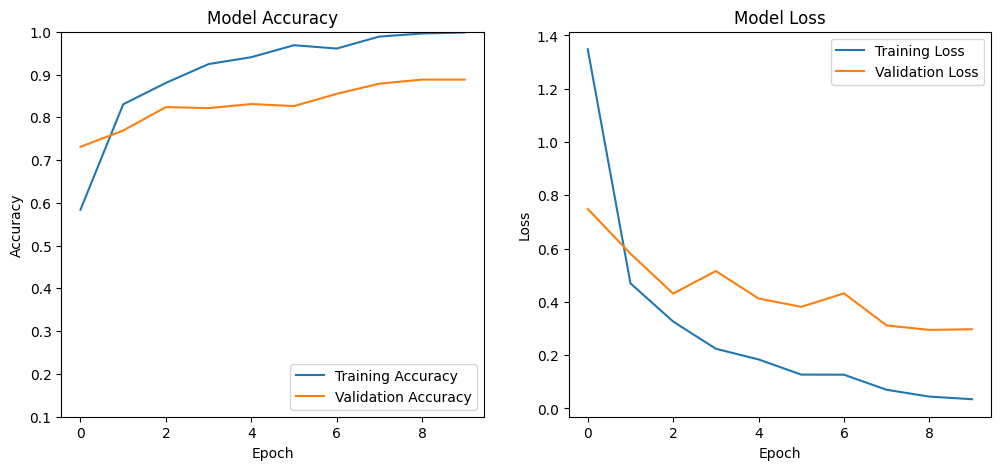

In [21]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['accuracy'])
plt.plot(history_CNN2['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [22]:
vgg_model.save('VGG16_model.h5')

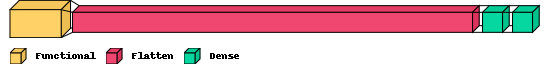

In [23]:
import visualkeras

visualkeras.layered_view(vgg_model,  legend=True)